# **POSE DETECTION**

# THIS IS THE CODE THAT CLASSIFIES THE YOGA ASANAS

# **Import libraries**

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
import glob

import concurrent.futures
from tqdm import tqdm
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**SETTINGS**

In [2]:
# Plots display settings
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 14})

# Model paths: single person pose classification
model_path = 'https://tfhub.dev/google/movenet/singlepose/thunder/3'  # Larger version
model_path_light = 'https://tfhub.dev/google/movenet/singlepose/lightning/3'  # Lighter version

# Directory containing 107 subfolders with images
data_directory_path = '../input/yoga-pose-image-classification-dataset/dataset'

# TensorFlow settings
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SIZE = 256
IMG_SIZE_LIGHT = 192
BATCH_SIZE = 32

**The 17 keypoints identified by the algorithm are:**

**-> nose -> left eye -> right eye -> left ear -> right ear -> left shoulder -> right shoulder -> left elbow -> right elbow -> left wrist -> right wrist -> left hip -> right hip -> left knee -> right knee -> left ankle -> right ankle These keypoints are used to classify the image into one of 107 possible yoga poses**

In [3]:
# 17 keypoints in the model output
kp_descriptions = [
    'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear',
    'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
    'left_wrist', 'right_wrist', 'left_hip', 'right_hip',
    'left_knee', 'right_knee', 'left_ankle', 'right_ankle'
]

In [4]:
def get_image(path: str, flip=False) -> tf.Tensor:
    """Function loads image from a file and resizes it.
    :param path: Path to image file
    :param flip: Optional argument indicating whether to flip the image left to right
    :return: Tensor with resized image data
    """
    image = tf.expand_dims(tf.compat.v1.image.decode_jpeg(
        tf.io.read_file(path), channels=3), axis=0)
    if flip:
        image = tf.image.flip_left_right(image)
    # Resize and pad the image to keep the aspect ratio and fit the expected size
    image = tf.cast(tf.image.resize_with_pad(image, IMG_SIZE_LIGHT, IMG_SIZE_LIGHT), dtype=tf.int32)
    return image

In [5]:
def configure_for_performance(ds: tf.data.Dataset) -> tf.data.Dataset:
    """Function applies batch() and prefetch() functions
    to the dataset to optimize data processing.
    :param ds: TensorFlow Dataset object
    :return Batched TensorFlow Dataset object
    """
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE).cache()
    return ds

In [6]:
def movenet_inference(model: tf.keras.Model, path: str, flip=False) -> tf.Tensor:
    """Function transforms an image to a tensor of shape [1, 17, 3]
    containing y and x coordinates and confidence level for 17 keypoints.
    :param model: movenet model in tensorflow format
    :param path: Path to image file
    :param flip: Optional argument indicating whether to flip the image left to right
    :return: Tensor with data for 17 keypoints
    """
    keypoints = model.inference_fn(get_image(path, flip))[0]
    return keypoints

In [7]:
def movenet_inference_flat(model: tf.keras.Model, path: str, flip=False) -> np.array:
    """Function transforms an image to a numpy array shape [51,]
    containing y and x coordinates and confidence level for 17 keypoints.
    :param model: movenet model in tensorflow format
    :param path: Path to image file
    :param flip: Optional argument indicating whether to flip the image left to right
    :return: 1D array with 51 values
    """
    keypoints = model.inference_fn(get_image(path, flip))[0][0].numpy().flatten()
    return keypoints

In [8]:
def movenet_serving(model: tf.keras.Model, path: str, flip=False) -> tf.Tensor:
    """Function transforms an image to a tensor of shape [1, 17, 3]
    containing y and x coordinates and confidence level for 17 keypoints.
    :param model: Movenet model in tensorflow format
    :param path: Path to image file
    :param flip: Optional argument indicating whether to flip the image left to right
    :return: Tensor with data for 17 keypoints
    """
    keypoints = model(get_image(path, flip))['output_0'][0]
    return keypoints

In [9]:
def movenet_serving_flat(model: tf.keras.Model, path: str, flip=False) -> np.array:
    """Function transforms an image to a numpy array shape [51,]
    containing y and x coordinates and confidence level for 17 keypoints.
    :param model: Movenet model in tensorflow format
    :param path: Path to image file
    :param flip: Optional argument indicating whether to flip the image left to right
    :return: 1D array with 51 values
    """
    keypoints = model(get_image(path, flip))['output_0'][0][0].numpy().flatten()
    return keypoints

In [10]:
def display_images():
    """Function displays 100 examples of images
    belonging to different classes in 5 x 5 grids.
    """
    nrows = ncols = 5
    class_n = 0

    for pose in classes_df['pose'].unique():

        if class_n > 100:
            break

        class_n += 1

        if class_n % 25 == 1:
            fig = plt.gcf()
            fig.set_size_inches(ncols * 2.7, nrows * 2.7)

        image_path = classes_df[classes_df['pose'] == pose]['path'].iloc[0]
        image = mpimg.imread(image_path)
        plt.subplot(nrows, ncols, class_n % 25 + 1)
        plt.imshow(image)
        plt.axis('Off')
        plt.title(pose)

        if class_n % 25 == 1 and class_n != 1:
            plt.show()

In [11]:
def display_keypoints(path: str, points: tf.Tensor):
    """Function displays an image with marked keypoints.
    :param path: Path to the image file
    :param points: Tensor of keypoints in the shapes of [17, 3],
    where 0-th column contains y coordinates, 1st column - x coordinates,
    2nd column - confidence score
    """
    # Convert coordinates from range [0, 1] to absolute positions
    y = points[:, 0] * IMG_SIZE_LIGHT
    x = points[:, 1] * IMG_SIZE_LIGHT

    # Read image from file and resize with padding
    image = tf.compat.v1.image.decode_jpeg(tf.io.read_file(path), channels=3)
    image = tf.image.resize_with_pad(image, IMG_SIZE_LIGHT, IMG_SIZE_LIGHT)
    image = tf.cast(image, dtype=tf.uint8)

    plt.imshow(image)
    plt.scatter(x, y)
    plt.axis('Off')
    plt.show()

In [12]:
def distance(coordinates: np.array) -> tuple:
    """Function calculates distance between two keypoints
    described by x and y coordinates relative to image size.
    :param coordinates: Array with 4 values [x coordinate of the 1st keypoint,
    y coordinate of the 1st keypoint, x coordinate of the 2nd keypoint,
    y coordinate of the 2nd keypoint]
    :return: Tuple with 3 values [Euclidean distance between two points,
    distance between x coordinates, distance between y coordinates]
    """
    x_1, y_1, x_2, y_2 = coordinates
    hor_dist = abs(x_1 - x_2)
    vert_dist = abs(y_1 - y_2)
    dist = np.sqrt(hor_dist ** 2 + vert_dist ** 2)
    return dist, hor_dist, vert_dist

In [13]:
def is_higher(coordinates: np.array) -> int:
    """Function identifies relative positions
    of two y coordinates in vertical direction.
    :param coordinates: Array with 2 values [y coordinate of the 1st keypoint,
    y coordinate of the 2nd keypoint]
    :return: Binary value (1 - if the 1st coordinate is higher than 2nd,
    0 - if the 1st coordinate is lower than 2nd coordinate)
    """
    y_1, y_2 = coordinates
    res = int((y_1 - y_2) > 0)
    return res

In [14]:
def add_pos_features(df: pd.DataFrame, drop_scores=False) -> pd.DataFrame:
    """Function creates positional features based on keypoints.
    :param df: DataFrame with keypoints (x and y coordinates)
    :param drop_scores: Optional argument specifying whether to drop confidence scores
    :return: Updated DataFrame
    """
    # Distance between left and right points in pairs of limbs
    # relative to image size (Euclidean, horizontal and vertical)
    for point_type in ('elbow', 'wrist', 'knee', 'ankle'):
        d = np.apply_along_axis(
            distance, 1, df[[
                f'left_{point_type}_x', f'left_{point_type}_y',
                f'right_{point_type}_x', f'right_{point_type}_y'
            ]].values)
        df[f'{point_type}s_dist'], df[f'{point_type}s_hor_dist'], \
        df[f'{point_type}s_vert_dist'] = d.transpose()

    # Distance between specific keypoint pairs
    for point_1, point_2 in [('wrist', 'ankle'), ('wrist', 'knee'),
                             ('wrist', 'hip'), ('wrist', 'elbow'),
                             ('wrist', 'shoulder'), ('wrist', 'ear'),
                             ('ankle', 'hip'), ('ankle', 'ear'),
                             ('elbow', 'knee'), ('knee', 'hip')]:
        for side_1 in ('left', 'right'):
            for side_2 in ('left', 'right'):
                d = np.apply_along_axis(
                    distance, 1, df[[
                        f'{side_1}_{point_1}_x', f'{side_1}_{point_1}_y',
                        f'{side_2}_{point_2}_x', f'{side_2}_{point_2}_y'
                    ]].values)
                df[f'{side_1}_{point_1}_{side_2}_{point_2}_dist'], \
                df[f'{side_1}_{point_1}_{side_2}_{point_2}_hor_dist'], \
                df[f'{side_1}_{point_1}_{side_2}_{point_2}_vert_dist'] = d.transpose()

    # Relative upper / lower positions of specific keypoints (binary values: 0/1)
    for point_1, point_2 in combinations(['ear', 'hip', 'knee', 'ankle', 'wrist', 'elbow'], 2):
        for side_1 in ('left', 'right'):
            for side_2 in ('left', 'right'):
                df[f'{side_1}_{point_1}_{side_2}_{point_2}'] = np.apply_along_axis(
                    is_higher, 1, df[[
                        f'{side_1}_{point_1}_y', f'{side_2}_{point_2}_y'
                    ]].values)

    if drop_scores:
        columns = filter(lambda x: x.find('score') == -1, df.columns)
        df = df[columns]

    print('Positional features added. DataFrame shape:', df.shape)

    return df

In [15]:
def get_model(n_features: int, n_classes, dense_neurons: list) -> tf.keras.Model:
    """Function creates a Densely Connected Neural Network.
    :param n_features: Number of input features
    :param n_classes: Number of classes
    :param dense_neurons: List contains number of neurons in dense layers
    :return: Compiled tensorflow model
    """
    model = tf.keras.Sequential(
        [tf.keras.layers.Input(shape=(n_features,))]
    )

    for n_neurons in dense_neurons:
        model.add(tf.keras.layers.Dense(
            n_neurons, activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(0.001))
        )

    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    model.summary()

    return model

In [16]:
def train_model(model: tf.keras.Model,
                train_ds: tf.data.Dataset,
                val_ds: tf.data.Dataset) -> tf.keras.Model:
    """Function trains the model and evaluates it's performance,
    displays training metrics.
    :param model: Untrained model
    :param train_ds: Training Dataset containing input data and labels
    :param val_ds: Validation Dataset containing input data and labels
    :return: Trained model
    """
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5,
                                                  restore_best_weights=True)

    history = model.fit(train_ds, validation_data=val_ds,
                        epochs=100, verbose=2, callbacks=[early_stop],
                        use_multiprocessing=True, workers=-1)

    loss, acc = model.evaluate(valid_ds)
    print(f'Validation loss: {loss}\nValidation accuracy: {acc}')
    plot_history(history)

    return model

In [17]:
def plot_history(hist):
    """Function plots a chart with training and validation metrics.
    :param hist: Tensorflow history object from model.fit()
    """
    # Losses and metrics
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['sparse_categorical_accuracy']
    val_acc = hist.history['val_sparse_categorical_accuracy']

    # Epochs to plot along x axis
    x_axis = range(1, len(loss) + 1)

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

    ax1.plot(x_axis, loss, 'bo', label='Training')
    ax1.plot(x_axis, val_loss, 'ro', label='Validation')
    ax1.set_title('Categorical crossentropy')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(x_axis, acc, 'bo', label='Training')
    ax2.plot(x_axis, val_acc, 'ro', label='Validation')
    ax2.set_title('Categorical accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

DataFrame shape: (5994, 3)
                                                path              pose  label
0  ../input/yoga-pose-image-classification-datase...  virabhadrasana i    100
1  ../input/yoga-pose-image-classification-datase...  virabhadrasana i    100
2  ../input/yoga-pose-image-classification-datase...  virabhadrasana i    100
3  ../input/yoga-pose-image-classification-datase...  virabhadrasana i    100
4  ../input/yoga-pose-image-classification-datase...  virabhadrasana i    100


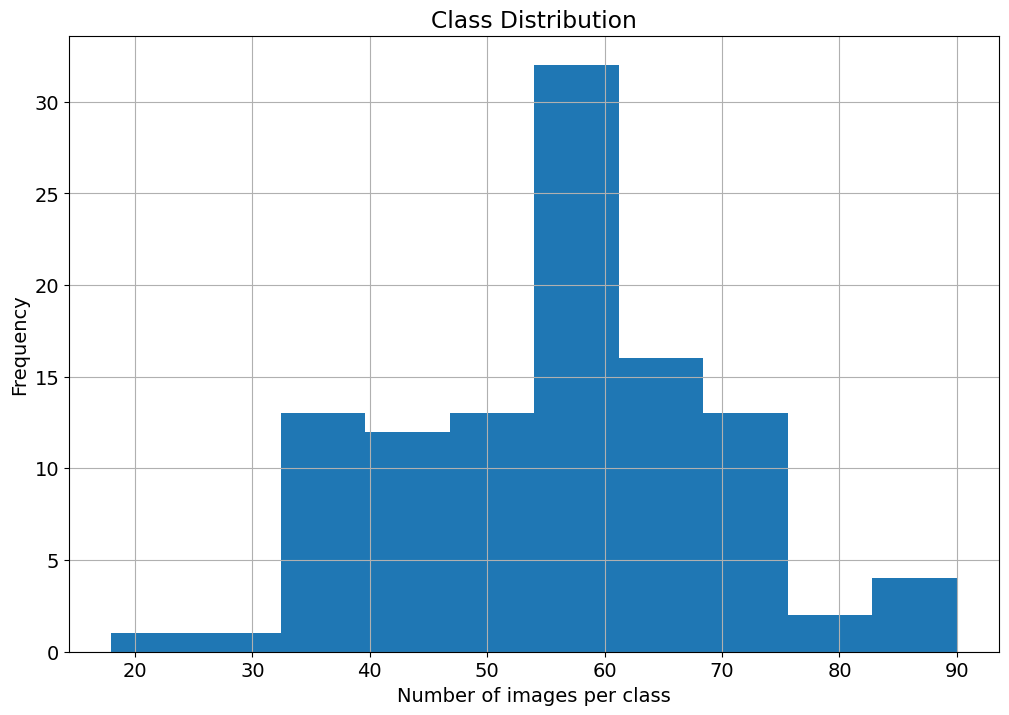

In [18]:
# Create a DataFrame with 3 columns: image path, class name and class label
image_paths = glob.glob(f'{data_directory_path}/*/*.*')
classes_df = pd.DataFrame({'path': list(image_paths)})
classes_df['pose'] = classes_df['path'].apply(lambda x: x.split('/')[-2])
classes_df['label'] = LabelEncoder().fit_transform(classes_df['pose'])
print(f'DataFrame shape: {classes_df.shape}')
print(classes_df.head())

# Balance of classes
balance = classes_df['pose'].value_counts()
balance.hist(bins=10)
plt.xlabel('Number of images per class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

In [19]:
# Pretrained model for pose classification
hub_model = hub.load(model_path_light)
movenet = hub_model.signatures['serving_default']

In [20]:
# Model inference for a single image
example_path = classes_df['path'][1]
example_image = get_image(example_path)
outputs = movenet(example_image)
print(outputs)

{'output_0': <tf.Tensor: shape=(1, 1, 17, 3), dtype=float32, numpy=
array([[[[0.31911364, 0.45288855, 0.83883977],
         [0.30238354, 0.46642536, 0.80941164],
         [0.3025164 , 0.4594308 , 0.6214596 ],
         [0.3176945 , 0.5154166 , 0.6475287 ],
         [0.31175008, 0.5036018 , 0.68834054],
         [0.3902343 , 0.5393153 , 0.87631196],
         [0.38730627, 0.48170936, 0.71608824],
         [0.23608384, 0.5165397 , 0.71631503],
         [0.23879686, 0.47144243, 0.630029  ],
         [0.09525474, 0.51541495, 0.6910184 ],
         [0.09463967, 0.47679767, 0.54404837],
         [0.6604334 , 0.5326041 , 0.8106913 ],
         [0.6625204 , 0.46489304, 0.83036613],
         [0.779283  , 0.72244155, 0.9245886 ],
         [0.7321596 , 0.2848993 , 0.9327385 ],
         [0.86869276, 0.8646586 , 0.9116677 ],
         [0.92697495, 0.23622158, 0.93056077]]]], dtype=float32)>}


In [21]:
# Output is a dictionary with [1, 1, 17, 3] tensor.
# For each image the model extracts 17 keypoints: y and x coordinates and confidence level.
keypoints = outputs['output_0']
print(keypoints)

tf.Tensor(
[[[[0.31911364 0.45288855 0.83883977]
   [0.30238354 0.46642536 0.80941164]
   [0.3025164  0.4594308  0.6214596 ]
   [0.3176945  0.5154166  0.6475287 ]
   [0.31175008 0.5036018  0.68834054]
   [0.3902343  0.5393153  0.87631196]
   [0.38730627 0.48170936 0.71608824]
   [0.23608384 0.5165397  0.71631503]
   [0.23879686 0.47144243 0.630029  ]
   [0.09525474 0.51541495 0.6910184 ]
   [0.09463967 0.47679767 0.54404837]
   [0.6604334  0.5326041  0.8106913 ]
   [0.6625204  0.46489304 0.83036613]
   [0.779283   0.72244155 0.9245886 ]
   [0.7321596  0.2848993  0.9327385 ]
   [0.86869276 0.8646586  0.9116677 ]
   [0.92697495 0.23622158 0.93056077]]]], shape=(1, 1, 17, 3), dtype=float32)


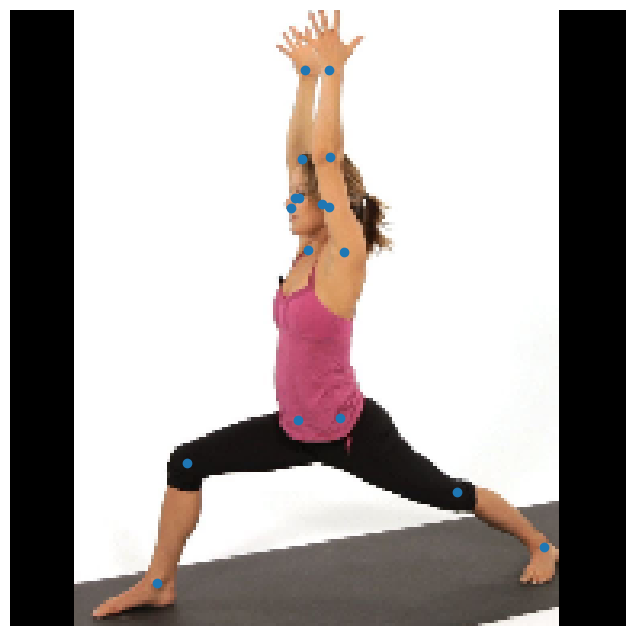

In [22]:
# Display keypoints superimposed on the image
display_keypoints(path=example_path, points=keypoints[0][0])

In [23]:
# The same result can be achieved using inference_fn()
print(hub_model.inference_fn(example_image))

tf.Tensor(
[[[[0.31911364 0.45288855 0.83883977]
   [0.30238354 0.46642536 0.80941164]
   [0.3025164  0.4594308  0.6214596 ]
   [0.3176945  0.5154166  0.6475287 ]
   [0.31175008 0.5036018  0.68834054]
   [0.3902343  0.5393153  0.87631196]
   [0.38730627 0.48170936 0.71608824]
   [0.23608384 0.5165397  0.71631503]
   [0.23879686 0.47144243 0.630029  ]
   [0.09525474 0.51541495 0.6910184 ]
   [0.09463967 0.47679767 0.54404837]
   [0.6604334  0.5326041  0.8106913 ]
   [0.6625204  0.46489304 0.83036613]
   [0.779283   0.72244155 0.9245886 ]
   [0.7321596  0.2848993  0.9327385 ]
   [0.86869276 0.8646586  0.9116677 ]
   [0.92697495 0.23622158 0.93056077]]]], shape=(1, 1, 17, 3), dtype=float32)


In [24]:
# We can convert model output into a 1D array with 51 columns
# representing triplets of values: x, y, confidence
print(hub_model.inference_fn(example_image)[0][0].numpy().flatten())

[0.31911364 0.45288855 0.83883977 0.30238354 0.46642536 0.80941164
 0.3025164  0.4594308  0.6214596  0.3176945  0.5154166  0.6475287
 0.31175008 0.5036018  0.68834054 0.3902343  0.5393153  0.87631196
 0.38730627 0.48170936 0.71608824 0.23608384 0.5165397  0.71631503
 0.23879686 0.47144243 0.630029   0.09525474 0.51541495 0.6910184
 0.09463967 0.47679767 0.54404837 0.6604334  0.5326041  0.8106913
 0.6625204  0.46489304 0.83036613 0.779283   0.72244155 0.9245886
 0.7321596  0.2848993  0.9327385  0.86869276 0.8646586  0.9116677
 0.92697495 0.23622158 0.93056077]


In [25]:
# Inference time for 50 images using inference_fn() and multiprocessing
start = time.perf_counter()
keypoints = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(movenet_inference_flat, hub_model, path) for path in classes_df['path'].head(50)]
    for f in tqdm(concurrent.futures.as_completed(results)):
        keypoints.append(f.result())

finish = time.perf_counter()
print(f'Finished in {round(finish - start, 2)} second(s).')

50it [00:01, 41.37it/s]

Finished in 1.23 second(s).


In [26]:
# Inference time for 50 images using default serving method and multiprocessing
start = time.perf_counter()
keypoints = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(movenet_serving_flat, movenet, path) for path in classes_df['path'].head(50)]
    for f in tqdm(concurrent.futures.as_completed(results)):
        keypoints.append(f.result())

finish = time.perf_counter()
print(f'Finished in {round(finish - start, 2)} second(s).')

50it [00:01, 45.46it/s]

Finished in 1.17 second(s).


In [27]:
# Inference time for 50 images processed consecutively
start = time.perf_counter()
keypoints = []

for path in tqdm(classes_df['path'].head(50)):
    img = movenet_inference_flat(hub_model, path)
    keypoints.append(img)

finish = time.perf_counter()
print(f'Finished in {round(finish - start, 2)} second(s).')

100%|██████████| 50/50 [00:02<00:00, 21.15it/s]

Finished in 2.37 second(s).


In [28]:
# Convert all images into keypoints tensors of shape [51,] and create a list
start = time.perf_counter()
keypoints = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(movenet_inference_flat, hub_model, path) for path in classes_df['path']]
    for f in tqdm(concurrent.futures.as_completed(results)):
        keypoints.append(f.result())

finish = time.perf_counter()
print(f'Finished in {round(finish - start, 2)} second(s).')

keypoints_df = pd.DataFrame(keypoints)
print('Original keypoints extracted. Shape:', keypoints_df.shape)

5994it [01:53, 52.79it/s]


Finished in 114.23 second(s).
Original keypoints extracted. Shape: (5994, 51)


In [29]:
# Repeat this operation for all images flipped left to right.
# This will double total number of images in all classes.
start = time.perf_counter()
keypoints_fl = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(movenet_inference_flat, hub_model, path, True) for path in classes_df['path']]
    for f in tqdm(concurrent.futures.as_completed(results)):
        keypoints_fl.append(f.result())

finish = time.perf_counter()
print(f'Finished in {round(finish - start, 2)} second(s).')

# Create a matrix of all keypoints n_samples x 51 columns
keypoints_fl = np.vstack([keypoints + keypoints_fl])
keypoints_fl_df = pd.DataFrame(keypoints_fl)
print('Original and flipped keypoints extracted. Shape:', keypoints_fl_df.shape)

5994it [01:55, 51.70it/s]

Finished in 116.41 second(s).
Original and flipped keypoints extracted. Shape: (11988, 51)


In [30]:
# Rename columns in the DataFrames according to the values
columns = []
for point in kp_descriptions:
    for value in ('y', 'x', 'score'):
        columns.append(f'{point}_{value}')

keypoints_df.columns = columns
keypoints_fl_df.columns = columns
print(keypoints_df.head())

     nose_y    nose_x  nose_score  left_eye_y  left_eye_x  left_eye_score  \
0  0.308611  0.617859    0.641015    0.289973    0.609109        0.576701   
1  0.309912  0.516782    0.492857    0.296089    0.506527        0.495896   
2  0.180621  0.540042    0.706191    0.175979    0.519853        0.566247   
3  0.275148  0.417020    0.586998    0.267665    0.432914        0.572149   
4  0.255860  0.658844    0.789780    0.275352    0.679489        0.819613   

   right_eye_y  right_eye_x  right_eye_score  left_ear_y  ...  \
0     0.289795     0.608100         0.546306    0.304810  ...   
1     0.295336     0.507330         0.586746    0.319660  ...   
2     0.180109     0.517848         0.572863    0.226868  ...   
3     0.272074     0.429432         0.707868    0.309382  ...   
4     0.267058     0.673772         0.623726    0.338829  ...   

   left_knee_score  right_knee_y  right_knee_x  right_knee_score  \
0         0.935492      0.806877      0.368088          0.834136   
1         

In [31]:
keypoints_df

,nose_y,nose_x,nose_score,left_eye_y,left_eye_x,left_eye_score,right_eye_y,right_eye_x,right_eye_score,left_ear_y,...,left_knee_score,right_knee_y,right_knee_x,right_knee_score,left_ankle_y,left_ankle_x,left_ankle_score,right_ankle_y,right_ankle_x,right_ankle_score
0,0.308611,0.617859,0.641015,0.289973,0.609109,0.576701,0.289795,0.608100,0.546306,0.304810,...,0.935492,0.806877,0.368088,0.834136,0.929374,0.737040,0.931183,0.934638,0.204357,0.896081
1,0.309912,0.516782,0.492857,0.296089,0.506527,0.495896,0.295336,0.507330,0.586746,0.319660,...,0.878234,0.786008,0.359412,0.762973,0.910826,0.717085,0.689342,0.913484,0.216334,0.826524
2,0.180621,0.540042,0.706191,0.175979,0.519853,0.566247,0.180109,0.517848,0.572863,0.226868,...,0.742248,0.835772,0.392069,0.664592,0.904231,0.856923,0.825592,0.880723,0.076298,0.663992
3,0.275148,0.417020,0.586998,0.267665,0.432914,0.572149,0.272074,0.429432,0.707868,0.309382,...,0.782171,0.737918,0.281917,0.823847,0.934063,0.788817,0.878482,0.925715,0.292031,0.857293
4,0.255860,0.658844,0.789780,0.275352,0.679489,0.819613,0.267058,0.673772,0.623726,0.338829,...,0.602725,0.665068,0.215386,0.428866,0.915822,0.927081,0.543393,0.913741,0.157901,0.330132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5989,0.132261,0.527420,0.553980,0.109480,0.554592,0.598967,0.099774,0.514052,0.528656,0.110273,...,0.215371,0.693721,0.484857,0.677292,0.934423,0.522347,0.344556,0.928162,0.521295,0.604071
5990,0.188798,0.536957,0.460986,0.169678,0.559567,0.598218,0.160826,0.520602,0.632936,0.168810,...,0.241517,0.680158,0.473995,0.509850,0.933119,0.526068,0.368993,0.934975,0.520101,0.547579
5991,0.101065,0.485683,0.495157,0.079428,0.510627,0.701648,0.076280,0.464434,0.755274,0.096532,...,0.279822,0.698280,0.458954,0.604323,0.903966,0.526696,0.408049,0.872516,0.516182,0.562139
5992,0.150245,0.530165,0.724410,0.125883,0.555902,0.647915,0.122014,0.507495,0.557404,0.135934,...,0.418011,0.712730,0.492155,0.341129,0.889357,0.531520,0.366244,0.882993,0.528429,0.180458


In [32]:
# Create additional features based on distances between keypoints
# and their position relative to each other.
# x and y coordinates are values between 0 and 1
# (positions relative to image frame).
keypoints_df = add_pos_features(keypoints_df, drop_scores=True)
keypoints_fl_df = add_pos_features(keypoints_fl_df, drop_scores=True)
print(keypoints_df.head())


Positional features added. DataFrame shape: (5994, 226)
Positional features added. DataFrame shape: (11988, 226)
     nose_y    nose_x  left_eye_y  left_eye_x  right_eye_y  right_eye_x  \
0  0.308611  0.617859    0.289973    0.609109     0.289795     0.608100   
1  0.309912  0.516782    0.296089    0.506527     0.295336     0.507330   
2  0.180621  0.540042    0.175979    0.519853     0.180109     0.517848   
3  0.275148  0.417020    0.267665    0.432914     0.272074     0.429432   
4  0.255860  0.658844    0.275352    0.679489     0.267058     0.673772   

   left_ear_y  left_ear_x  right_ear_y  right_ear_x  ...  \
0    0.304810    0.561468     0.302145     0.562881  ...   
1    0.319660    0.463133     0.318601     0.462351  ...   
2    0.226868    0.494767     0.237414     0.492026  ...   
3    0.309382    0.453309     0.305054     0.454764  ...   
4    0.338829    0.679828     0.322618     0.673535  ...   

   right_ankle_left_wrist  right_ankle_right_wrist  left_ankle_left_elbow  

In [33]:
# Add target values to the DataFrame with keypoints for original images
keypoints_df['label'] = classes_df['label'].values

# Add 2 sets of target values - for original and flipped images
keypoints_fl_df['label'] = np.hstack(
    [classes_df['label'].values, classes_df['label'].values]
)

# Save the data for future use
keypoints_df.to_csv('keypoints.csv', index=False)
keypoints_fl_df.to_csv('keypoints_fl.csv', index=False)

/tmp/ipykernel_84/1130899420.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keypoints_df['label'] = classes_df['label'].values


In [34]:
# Remove target values from the DataFrame
y = keypoints_df.pop('label')
y_fl = keypoints_fl_df.pop('label')
n_features = len(keypoints_df.columns)

# Split keypoints data and labels into train and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(
    keypoints_df, y,
    stratify=y, test_size=0.1
)

x_train_fl, x_valid_fl, y_train_fl, y_valid_fl = train_test_split(
    keypoints_fl_df, y_fl,
    stratify=y_fl, test_size=0.1
)

In [35]:
# Create tensorflow datasets from input data and labels
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))

train_ds_fl = tf.data.Dataset.from_tensor_slices((x_train_fl, y_train_fl))
valid_ds_fl = tf.data.Dataset.from_tensor_slices((x_valid_fl, y_valid_fl))

# Use prefetch() and cache() to speed up training
train_ds = configure_for_performance(train_ds)
valid_ds = configure_for_performance(valid_ds)

train_ds_fl = configure_for_performance(train_ds_fl)
valid_ds_fl = configure_for_performance(valid_ds_fl)

In [36]:
# Densely connected neural network
model = get_model(
    n_features=n_features,
    n_classes=107,
    dense_neurons=[256, 256, 128]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               58112     
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 107)               13803     
                                                                 
Total params: 170,603
Trainable params: 170,603
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
169/169 - 2s - loss: 3.9714 - sparse_categorical_accuracy: 0.1973 - val_loss: 2.8758 - val_sparse_categorical_accuracy: 0.3867 - 2s/epoch - 10ms/step
Epoch 2/100
169/169 - 1s - loss: 2.5363 - sparse_categorical_accuracy: 0.4613 - val_loss: 2.3605 - val_sparse_categorical_accuracy: 0.5133 - 550ms/epoch - 3ms/step
Epoch 3/100
169/169 - 1s - loss: 2.1899 - sparse_categorical_accuracy: 0.5523 - val_loss: 2.2029 - val_sparse_categorical_accuracy: 0.5600 - 578ms/epoch - 3ms/step
Epoch 4/100
169/169 - 1s - loss: 2.0166 - sparse_categorical_accuracy: 0.5940 - val_loss: 2.1212 - val_sparse_categorical_accuracy: 0.5850 - 560ms/epoch - 3ms/step
Epoch 5/100
169/169 - 1s - loss: 1.8957 - sparse_categorical_accuracy: 0.6205 - val_loss: 2.0776 - val_sparse_categorical_accuracy: 0.5900 - 558ms/epoch - 3ms/step
Epoch 6/100
169/169 - 1s - loss: 1.8036 - sparse_categorical_accuracy: 0.6400 - val_loss: 2.0399 - val_sparse_categorical_accuracy: 0.5967 - 551ms/epoch - 3ms/step
Epoch 7/100
169/16

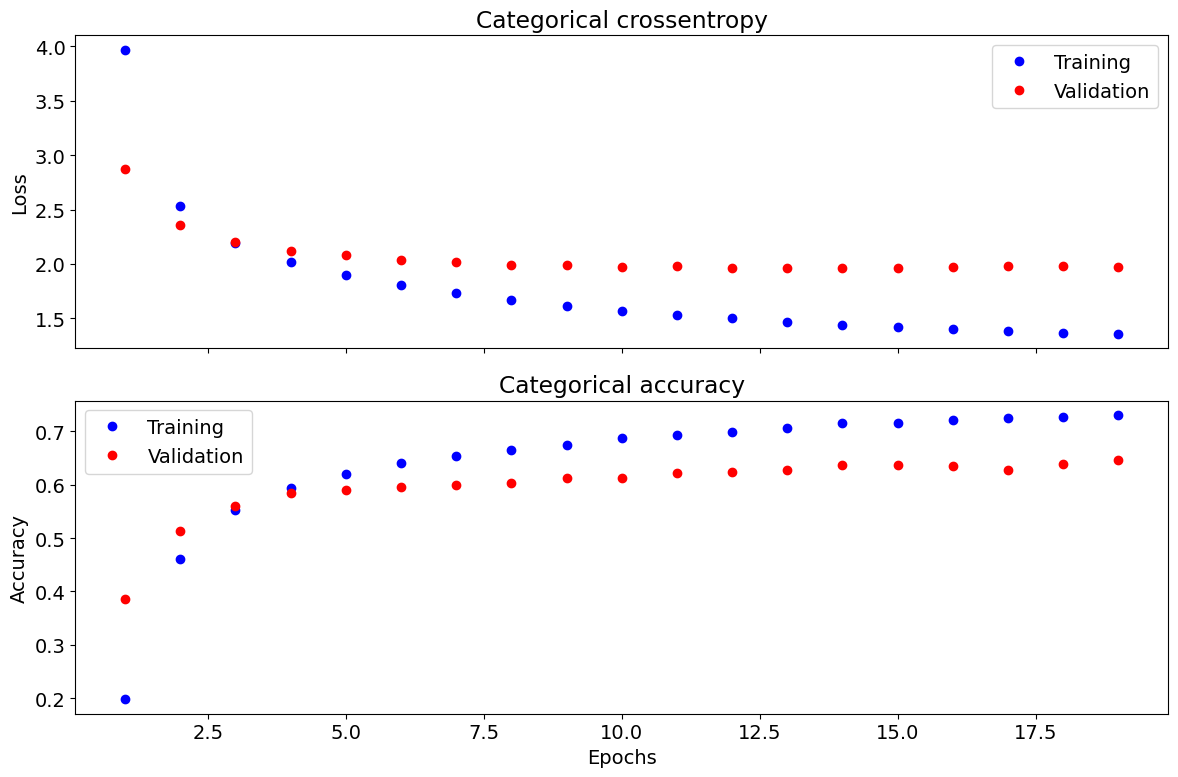

In [37]:
# Train the model on original images only
model = train_model(model, train_ds, valid_ds)